In [2]:
import pickle
import sys

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=256).as_hex())

sys.path.append('../src')
import analyze
import raybay

In [6]:
# Load data
grid = np.load('SBRT_lung_minsun/grid/res_grid.pkl', allow_pickle=True)
dummy = np.load('SBRT_lung_minsun/grid/res_lin_dummy_minimize.pkl', allow_pickle=True)
bayes_lin = np.load('SBRT_lung_minsun/grid/res_lin_gp_minimize.pkl', allow_pickle=True)
bayes_linquad = np.load('SBRT_lung_minsun/grid/res_linquad_gp_minimize.pkl', allow_pickle=True)

In [8]:
# Format parameter vectors
d2cm_grid = np.arange(0, 2500, 100)
rib_grid = np.arange(0, 4100, 100)
d2cm_dummy = [row[0]/100 for row in dummy.opt_result.x_iters]
rib_dummy = [row[1]/100 for row in dummy.opt_result.x_iters]
d2cm_bayes_lin = [row[0]/100 for row in bayes_lin.opt_result.x_iters]
rib_bayes_lin = [row[1]/100 for row in bayes_lin.opt_result.x_iters]
d2cm_bayes_linquad = [row[0]/100 for row in bayes_linquad.opt_result.x_iters]
rib_bayes_linquad = [row[1]/100 for row in bayes_linquad.opt_result.x_iters]

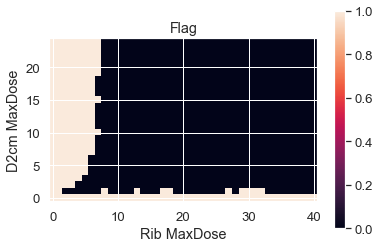

In [9]:
# Flags vs. parameters (0 = good, 1 = RayStation unable to normalize to PTV D95)
k = 0
F = np.zeros((len(rib_grid), len(d2cm_grid)))
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        F[jj, ii] = grid.flag_list[k]
        k += 1
plt.imshow(F.T, origin='lower')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Flag')
plt.colorbar();

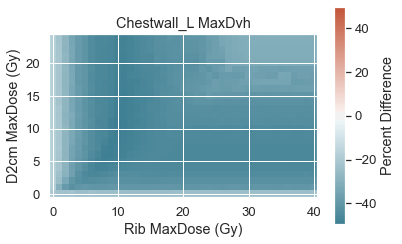

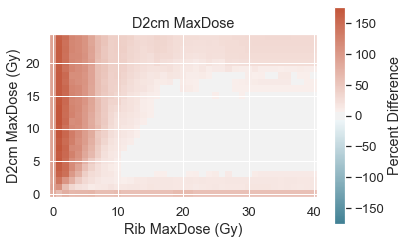

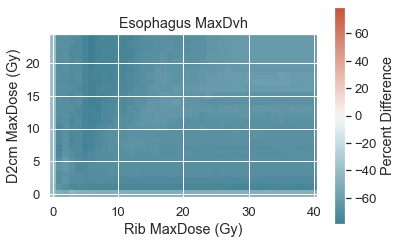

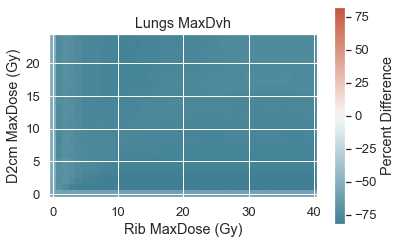

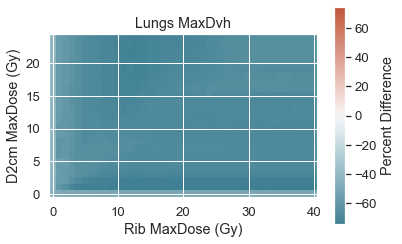

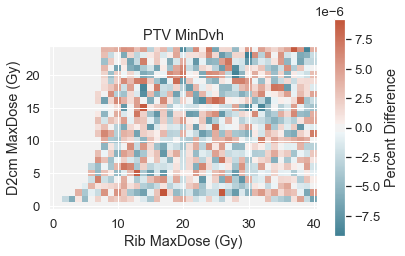

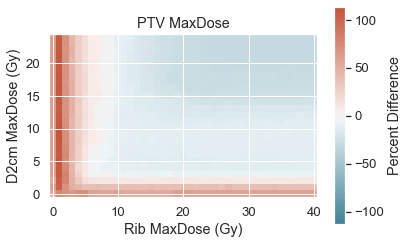

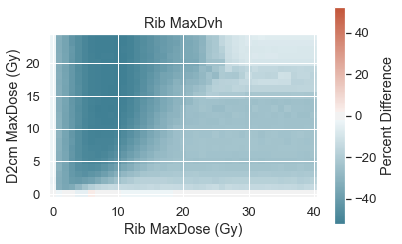

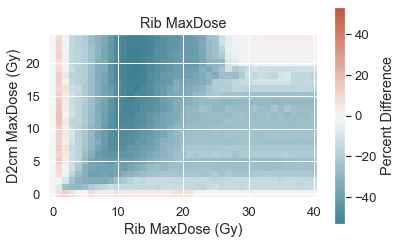

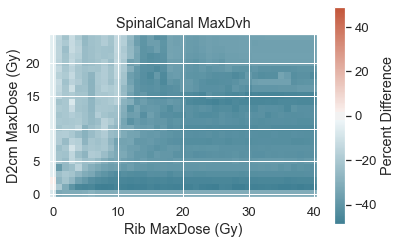

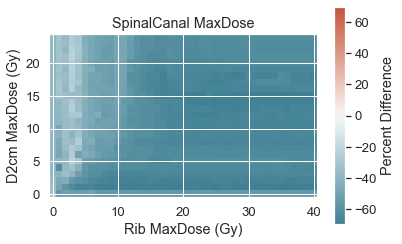

In [7]:
# Goal values vs. parameters (relative values)
for goal in grid.goal_dict:
    Z_goals = np.zeros_like(Z_flag)
    k = 0
    for ii in range(len(d2cm)):
        for jj in range(len(rib)):
            level = grid.goal_df.iloc[goal]['AcceptanceLevel']
            Z_goals[jj, ii] = 100*(grid.goal_dict[goal][k] - level)/level
            k += 1
    plt.figure()
    gval = np.max(np.abs(Z_goals))
    plt.imshow(Z_goals.T, origin='lower', cmap=my_cmap, vmin=-gval, vmax=gval)
    plt.xlabel('Rib MaxDose (Gy)')
    plt.ylabel('D2cm MaxDose (Gy)')
    plt.title(f"{grid.goal_df.iloc[goal]['Roi']} {grid.goal_df.iloc[goal]['Type']}")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Percent Difference')
    plt.savefig(f"gridGoal{goal}.png", bbox_inches='tight')

In [114]:
def plotgrid(grid, dummy, bayes, title):
    d2cm_grid = np.arange(0, 2500, 100)
    rib_grid = np.arange(0, 4100, 100)
    d2cm_dummy = [row[0]/100 for row in dummy.opt_result.x_iters]
    rib_dummy = [row[1]/100 for row in dummy.opt_result.x_iters]
    d2cm_bayes = [row[0]/100 for row in bayes.opt_result.x_iters]
    rib_bayes = [row[1]/100 for row in bayes.opt_result.x_iters]
    
    # Plot samples on grid
    k = 0
    Z = np.zeros((len(rib_grid), len(d2cm_grid)))
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            for index, row in bayes.goal_df.iterrows():
                Z[jj, ii] += raybay.get_term(grid.goal_dict[index][k], row['AcceptanceLevel'], row['Type'], row['Shape'])
            k += 1
    plt.imshow(Z.T, origin='lower')
    plt.plot(rib_dummy, d2cm_dummy, 'o')
    plt.plot(rib_bayes, d2cm_bayes, '.')
    idx_grid = np.unravel_index(np.argmax(Z), Z.shape)
    plt.plot(idx_grid[0], idx_grid[1], 'x')
    dummy_util = raybay.get_utility(bayes.goal_df, dummy.goal_dict)
    idx_dummy = np.argmax(dummy_util)
    plt.plot(rib_dummy[idx_dummy], d2cm_dummy[idx_dummy], 'x')
    plt.plot(bayes.opt_result.x[1]/100, bayes.opt_result.x[0]/100, 'x')
    plt.xlabel('Rib MaxDose (Gy)')
    plt.ylabel('D2cm MaxDose (Gy)')
    plt.title(title)
    plt.colorbar()
    plt.legend(['Dummy Samples', 'Bayes Samples', 'Grid Opt', 'Dummy Opt', 'Bayes Opt'],
               bbox_to_anchor=(1.5, 1))
    if 'Quad' in title:
        plt.clim([0, np.max(Z)])
    print(f'Grid Opt: {np.max(Z):.2f}, Rib: {idx_grid[0]:.2f}, D2cm: {idx_grid[1]:.2f}')
    print(f'Dummy Opt: {np.max(dummy_util):.2f}, Rib: {rib_dummy[idx_dummy]:.2f}, D2cm: {d2cm_dummy[idx_dummy]:.2f}')
    print(f'Bayes Opt: {-bayes.opt_result.fun:.2f}, Rib: {bayes.opt_result.x[1]/100:.2f}, D2cm: {bayes.opt_result.x[0]/100:.2f}')
                      
    # Plot Bayes samples on Bayes model
    Z_bayes = np.zeros_like(Z)
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            Z_bayes[jj, ii] = -bayes.opt_result.models[-1].predict(np.array([d2cm_grid[ii]/2400, rib_grid[jj]/4000]).reshape(1, -1))[0]
    plt.figure()
    plt.imshow(Z_bayes.T, origin='lower')
    plt.plot(rib_bayes, d2cm_bayes, '.')
    plt.plot(bayes.opt_result.x[1]/100, bayes.opt_result.x[0]/100,'x')
    plt.xlabel('Rib MaxDose (Gy)')
    plt.ylabel('D2cm MaxDose (Gy)')
    plt.title('Bayes ' + title + ' Model')
    plt.colorbar()
    if 'Quad' in title:
        plt.clim([0, np.max(Z)])
    
    # Plot convergence
    plt.figure()
    plt.plot([0, 49], [np.max(Z), np.max(Z)], ':')
    plt.plot(np.maximum.accumulate(dummy_util))
    plt.plot(-np.minimum.accumulate(bayes.opt_result.func_vals))
    plt.xlabel('Iteration')
    plt.ylabel('Utility')
    plt.legend(['Grid', 'Dummy', 'Bayes'])
    if 'Quad' in title:
        plt.ylim([0.9*np.max(Z), 1.01*np.max(Z)])

Grid Opt: 467.58, Rib: 14.00, D2cm: 17.00
Dummy Opt: 451.00, Rib: 15.10, D2cm: 21.41
Bayes Opt: 465.94, Rib: 15.25, D2cm: 18.42


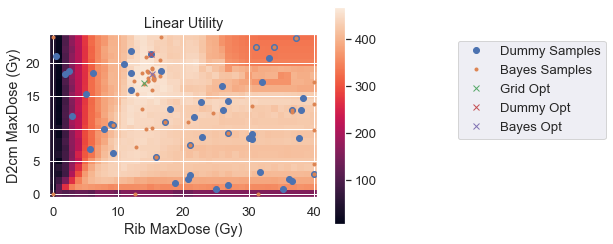

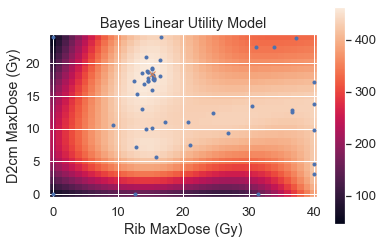

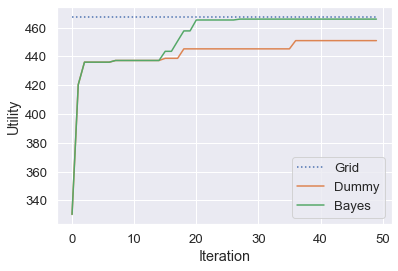

In [115]:
plotgrid(grid, dummy, bayes_lin, 'Linear Utility')

Grid Opt: 445.13, Rib: 19.00, D2cm: 15.00
Dummy Opt: 442.32, Rib: 22.64, D2cm: 14.03
Bayes Opt: 442.98, Rib: 25.68, D2cm: 13.30


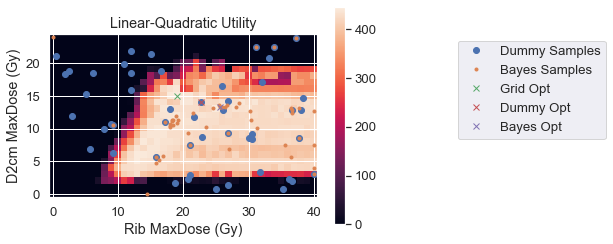

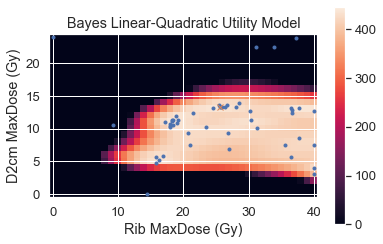

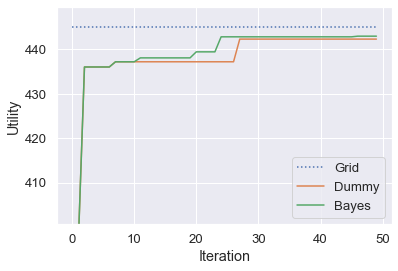

In [116]:
plotgrid(grid, dummy, bayes_linquad, 'Linear-Quadratic Utility')